In [59]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [60]:
import urllib.request
import requests
import nltk
import os.path
import numpy as np
import pandas as pd
import nltk
import glob
import re
import os
from bs4 import BeautifulSoup
from sklearn import feature_extraction
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# Part1 Scrape Web Page

In [61]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/crime',
             'https://inshorts.com/en/read/politics']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df


In [62]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,OPPO collaborates with MS Dhoni for #BeTheInfi...,OPPO's #BeTheInfinite campaign in association ...,technology
1,OPPO launches #BeTheInfinite campaign in colla...,OPPO's #BeTheInfinite campaign in association ...,technology
2,OnePlus reveals OnePlus 8T to come with 65-wat...,OnePlus has officially announced its upcoming ...,technology
3,Work from home culture to continue even after ...,Microsoft Co-founder and world's second-riches...,technology
4,Girl's tip helps expose apps that earned scamm...,A tip by a little girl from Prague helped digi...,technology
5,"App shows how users would look like in 'Asia',...",Photo editing app Gradient has been criticised...,technology
6,Some Tesla owners unable to unlock their cars ...,Tesla suffered a network outage on Wednesday t...,technology
7,Instagram doubles video length of Reels from 1...,Facebook-owned Instagram has begun rolling out...,technology
8,SoftBank to offer COVID-19 tests for $19 to co...,Japanese conglomerate SoftBank said it would o...,technology
9,Google Maps adds COVID-19 layer to display num...,Google has announced an update of Google Maps ...,technology


In [63]:
news_df.news_category.value_counts()

politics      25
sports        25
crime         25
technology    25
Name: news_category, dtype: int64

# Part2 Clustering and Topic modeling

## Text Preprocessing

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
# define the function for lemmatization
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens=[]
    for token in tokens:
        if re.search('[a-zA-Z]', token):  # save those which are non-numeric
            lemma_tokens.append(lemmatizer.lemmatize(token))
    return lemma_tokens

### tf-idf(term freq inverse document freq)

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
#chosen n-gram of three words. It will produce phrases containing upto three words
vectorizer = TfidfVectorizer(min_df=5,stop_words='english',tokenizer=lemma_tokenizer, ngram_range=(1,3)) 
#fit the vectorizer to documents
tfidf_matrix = vectorizer.fit_transform(news_df.news_article)

C:\Users\PINTU\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [66]:
terms = vectorizer.get_feature_names()
feature_array = np.array(terms)
tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]
n = 40
top_n = feature_array[tfidf_sorting][:n]
print(top_n)

['passed' 'sabha' 'include' 'home' 'tuesday' 'rajya sabha' 'rajya'
 'people' 'said' 'ha' 'india' 'including' 'family' 'kolkata' 'kkr'
 'farmer' 'government' 'ha said' 'history' 'ipl' 'hour' 'end' 'inside'
 'house' 'indian' 'facebook' 'year old' 'like' 'come' 'added' 'allegedly'
 'announced' 'app' 'arrested' 'asked' 'batsman' 'captain' 'case'
 'commentator' 'election']


## KMeans Clustering

In [67]:
from sklearn.cluster import KMeans  #find best K by reducing within cluster sum of squares measure
import matplotlib.pyplot as plt

num_clusters = range(1,8)  #test for K 1 to 8 clusters to get best cluster
KM = [KMeans(n_clusters=k).fit(tfidf_matrix) for k in num_clusters]  #fit the Kmeans to the tf-idf
centroids = [k.cluster_centers_ for k in KM]  #get all centroids

Text(0.5, 1.0, 'Elbow for KMeans clustering')

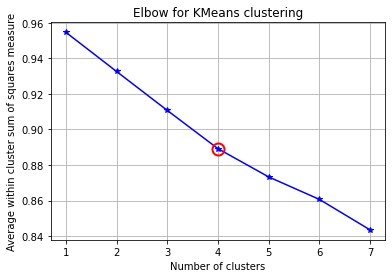

In [68]:
%matplotlib inline
from scipy.spatial.distance import cdist

D_k = [cdist(tfidf_matrix.toarray(), cent,'euclidean') for cent in centroids]  #euclidean as a distance measure
eucldist = [np.min(D,axis=1) for D in D_k]  #find minimum distance
avgWithinSM = [sum(d)/tfidf_matrix.shape[0] for d in eucldist]
kIdx = 3
# plot elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(num_clusters, avgWithinSM, 'b*-')
ax.plot(num_clusters[kIdx], avgWithinSM[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within cluster sum of squares measure')
plt.title('Elbow for KMeans clustering')

In [69]:
from sklearn.cluster import KMeans
best_K=4
model = KMeans(best_K)  
model.fit(tfidf_matrix)  #fit kmeans for k=4
clusters = model.labels_.tolist()
news = {'docs': news_df.news_article,'cluster': clusters}  #create dictionary of docs and cluster
frame = pd.DataFrame(news, index = [clusters] , columns = ['cluster'])  #this frame will help in cross-tabulation

In [70]:
print('Number of documents per cluster')
frame['cluster'].value_counts()   #get total document count grouped in each cluster

Number of documents per cluster


0    29
3    27
1    25
2    19
Name: cluster, dtype: int64

## Hierarchical Clustering

Clustering the data using hierarchical clustering with the ward's method.

Ward's minimum variance criterion minimizes the total within-cluster variance. To implement this method, at each step find the pair of clusters that leads to minimum increase in total within-cluster variance after merging. This increase is a weighted squared distance between cluster centers. At the initial step, all clusters are singletons (clusters containing a single point). To apply a recursive algorithm under this objective function, the initial distance between individual objects must be (proportional to) squared distance metric used.

Ward's method is the closest, by it properties and efficiency, to K-means clustering,hence it is chosen over single, complete and average linkage hierarchical clustering

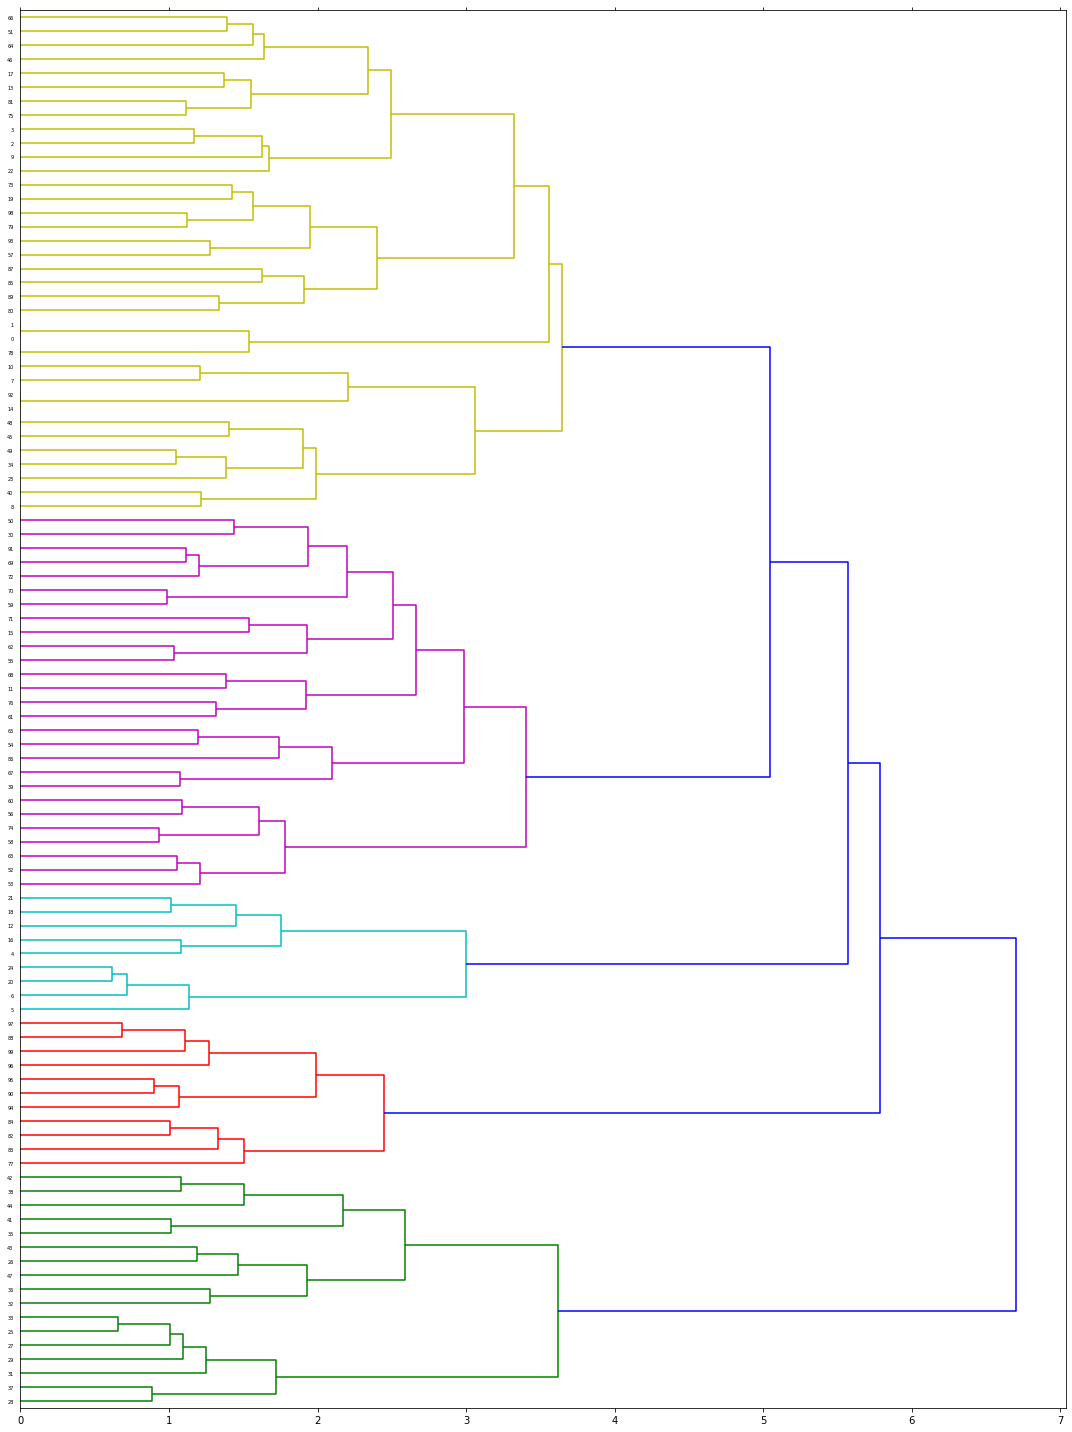

In [71]:

from scipy.cluster.hierarchy import ward,dendrogram
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)   #using cosine distance
linkage_matrix = ward(dist)   #get linkage matrix using ward's method

fig, ax = plt.subplots(figsize=(15, 20)) # set size 
ax = dendrogram(linkage_matrix, orientation="right")   #get the dendrogram

plt.tick_params(   #set tick parameters
    axis= 'x',          
    which='both',     
    bottom='off',      
    top='off',        
    labelbottom='off')

plt.tight_layout()

In [72]:
import numpy as np
from scipy.cluster.hierarchy import fcluster
# cut-off the tree to leave 4 clusters
clustering = fcluster(linkage_matrix,4,'maxclust')
print('Number of documents per cluster')
x = np.array(clustering)
unique, counts = np.unique(clustering, return_counts=True)
unique, counts = np.unique(x, return_counts=True)
print(np.asarray((unique, counts)).T)

Number of documents per cluster
[[ 1 17]
 [ 2 11]
 [ 3  9]
 [ 4 63]]


In [82]:
indexlist=[]   #get list to plot legends
legendlist=[]
legendlist.append('Digital Technology')
indices = [p for p, s in enumerate(news_df.news_article) if 'company' in s]   #find most frequent label for mobile
a = np.array(clustering[indices])
counts = np.bincount(a)
indexlist.append(np.argmax(counts))   

legendlist.append('Crime')
indices = [p for p, s in enumerate(news_df.news_article) if 'arrested' in s] #find most frequent label for crime
a = np.array(clustering[indices])
counts = np.bincount(a)
indexlist.append(np.argmax(counts)) 

legendlist.append('Politics')
indices = [p for p, s in enumerate(news_df.news_article) if 'election' in s]  #find most frequent label for politics
a = np.array(clustering[indices])
counts = np.bincount(a)
indexlist.append(np.argmax(counts))  

legendlist.append('Sports')
indices = [p for p, s in enumerate(news_df.news_article) if 'team' in s]  #find most frequent label for sport
a = np.array(clustering[indices])
counts = np.bincount(a)
indexlist.append(np.argmax(counts))

## Vizualization of Hierarchical clustering using Principal Component analysis

Text(0.5, 1.0, 'K-means clusters of the news documents')

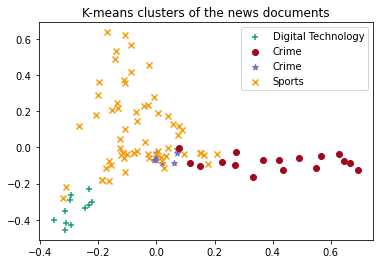

In [85]:
# again use PCA to plot clusters generated using hierarchical clustering
from sklearn.decomposition import PCA
import pylab as pl
pca = PCA(n_components=2).fit(tfidf_matrix.todense())
data2D = pca.transform(tfidf_matrix.todense())

for i in range(0, data2D.shape[0]):
    if clustering[i] == 2:
        c1 = plt.scatter(data2D[i,0],data2D[i,1],c='#1b9e77', marker='+')
    elif clustering[i] == 1:
        c2 = plt.scatter(data2D[i,0],data2D[i,1],c='#a3061e',marker='o')
    elif clustering[i] == 3:
        c3 = plt.scatter(data2D[i,0],data2D[i,1],c='#7570b3',marker='*')
    elif clustering[i] == 4:
        c4 = plt.scatter(data2D[i,0],data2D[i,1],c='#f99d0c',marker='x')
pl.legend([c1, c2, c3,c4],[legendlist[indexlist.index(3)],legendlist[indexlist.index(4)],legendlist[indexlist.index(4)],legendlist[indexlist.index(1)]])
pl.title('K-means clusters of the news documents')

## Topics(NMF and LDA)

Latent Dirichlet Allocation (LDA) is used to discover the topics that are present in a corpus. Non-negative Matrix Factorization (NMF), can also be used to find topics in text. The mathematical basis underpinning NMF is quite different from LDA.NMF sometimes produces more meaningful topics for smaller datasets.

Both algorithms are able to return the documents that belong to a topic in a corpus and the words that belong to a topic. LDA is based on probabilistic graphical modeling while NMF relies on linear algebra. Both algorithms take as input a bag of words matrix (i.e., each document represented as a row, with each columns containing the count of words in the corpus). The aim of each algorithm is then to produce 2 smaller matrices; a document to topic matrix and a word to topic matrix that when multiplied together reproduce the bag of words matrix with the lowest error.

Both NMF and LDA are not able to automatically determine the number of topics and this must be specified. I have used NMF as dataset is not quite big.

In [73]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

#function displays top words for a Topic
def display_topics(model, feature_names, no_top_words):
    s=","
    for topic_index, topic in enumerate(model.components_):
        print ("Keywords of topic %d:" % (topic_index))
        print (s.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [74]:
no_topics = 4  #four is selected as there are four clusters
# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)
no_top_words = 10
display_topics(nmf, terms, no_top_words)

Keywords of topic 0:
mp,sabha,rajya,rajya sabha,congress,party,said,added,passed,day
Keywords of topic 1:
ipl,run,mumbai,indian,captain,kxip,wa,rcb,batsman,team
Keywords of topic 2:
police,case,arrested,wa,ha,year,family,member,said,wife
Keywords of topic 3:
app,tiktok,user,u,company,time,ha,new,said,wednesday


#### Clearly documents related to 'politics','Sports','Digital Technology' and'Crime'. These are the four topics or theme of each of the four clusters.